In [44]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [45]:
df_ = pd.read_excel("/Users/yagizkarakaya/Desktop/DS&ML-Bootcamp/crmAnalytics/datasets/online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [46]:
df = df_.copy()

In [47]:
def check_df(dataframe, head=5):
    print("--------------------- SHAPE ---------------------")
    print(dataframe.shape)

    print("---------------------- TYPES --------------------")
    print(dataframe.dtypes)

    print("--------------------- HEAD ---------------------")
    print(dataframe.head(head))

    print("--------------------- QUANTILES ---------------------")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

--------------------- SHAPE ---------------------
(541910, 8)
---------------------- TYPES --------------------
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
--------------------- HEAD ---------------------
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00 2.5500   17850.0000  United Kingdom  
1 2010-12-01 08:26:00 3.3900   17850.0000  U

In [48]:
df.isnull().sum()


Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

###### Let's remove the Description and Customer ID variables that contain a lot of missing values in this dataset from the dataframe


In [49]:
df.dropna(inplace= True)

###### Let's check the missing values again

In [50]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

###### Let's check the descriptive statistics. There are negative values present. Why are these negative values present? Because there are invoice numbers starting with the letter "C" which indicate cancelled invoices. These invoices should be removed first

In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,406830.0000,12.0613,248.6931,-80995.0000,2.0000,5.0000,12.0000,80995.0000
Price,406830.0000,3.4605,69.3151,0.0000,1.2500,1.9500,3.7500,38970.0000
Customer ID,406830.0000,15287.6842,1713.6031,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000


In [52]:
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

###### Next problem is the presence of outliers. There are significant differences between the quartile values and the maximum values. First, we will determine the threshold value for outliers using outlier_thresholds(). Then, we will use the replace_with_thresholds() function to replace these outliers with the threshold values.

In [53]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    low_limit = dataframe.loc[(dataframe[variable] < low_limit), variable]
    up_limit = dataframe.loc[(dataframe[variable] > up_limit), variable]

###### We will use the replace_with_thresholds() function to suppress the outliers for the quantity and price variables.

In [54]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

###### To calculate the total price, we need to multiply the Quantity variable with the Price variable.

In [55]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

### Calculating RFM Metrics

###### First, let's determine the analysis date and name it as today_date. I chose the date that is 2 days after the last transaction date in the dataset as the today_date

In [56]:
today_date = dt.datetime(2011, 12, 11)

###### Now we can create the necessary dataframe for RFM analysis.

In [57]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'Invoice': lambda Invoice: Invoice.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [58]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [59]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0000,326,1,77183.6000
12347.0000,3,7,4310.0000
12348.0000,76,4,1797.2400
12349.0000,19,1,1757.5500
12350.0000,311,1,334.4000


In [60]:
rfm = rfm[rfm['Monetary'] > 0]

###### Now let's score the RFM metrics.

###### The important point here is that Recency is good for us when it has a low value, unlike the other variables. Therefore, we sort it in reverse order.


In [61]:
rfm['recency_score'] = pd.qcut(rfm['Recency'], 5, [5, 4, 3, 2, 1])
rfm['frequency_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, [1, 2, 3, 4, 5])  
rfm['monetary_score'] = pd.qcut(rfm['Monetary'], 5, [1, 2, 3, 4, 5]) 

###### We will now convert the R and F values to string type and concatenate them for the upcoming segmentation. We will not include Monetary.

In [62]:
rfm['RFM_SCORE'] = (rfm['recency_score'].astype('str') + rfm['frequency_score'].astype('str'))

In [63]:
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.0000,326,1,77183.6000,1,1,5,11
12347.0000,3,7,4310.0000,5,5,5,55
12348.0000,76,4,1797.2400,2,4,4,24
12349.0000,19,1,1757.5500,4,1,4,41
12350.0000,311,1,334.4000,1,1,2,11


![Segment](/https://cdn.enhencer.com/website-assets/images/blog/AdvantagesAndInefficaciesOfRFMSegmentation1.png)


In [64]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

###### Segmantation by scores

In [65]:
rfm['RFM_Segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

In [66]:
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,RFM_Segment
Customer ID,,,,,,,,
12346.0000,326,1,77183.6000,1,1,5,11,hibernating
12347.0000,3,7,4310.0000,5,5,5,55,champions
12348.0000,76,4,1797.2400,2,4,4,24,at_Risk
12349.0000,19,1,1757.5500,4,1,4,41,promising
12350.0000,311,1,334.4000,1,1,2,11,hibernating


###### How many customers are there in each segment created with R and F?

In [67]:
rfm.groupby("RFM_Segment").agg({"RFM_Segment": "count"})

,RFM_Segment
RFM_Segment,
about_to_sleep,352
at_Risk,593
cant_loose,63
champions,633
hibernating,1071
loyal_customers,819
need_attention,187
new_customers,42
potential_loyalists,484


### KMeans

###### Let's assign the standardized RF values to a new dataframe.

In [68]:
selected_df = rfm[['Recency', 'Frequency']]
selected_df.head()

,Recency,Frequency
Customer ID,,
12346.0000,326,1
12347.0000,3,7
12348.0000,76,4
12349.0000,19,1
12350.0000,311,1


######  Standardization applied for RF.


In [69]:
sc = MinMaxScaler()
sc.fit(selected_df)

MinMaxScaler()

###### Transforming the fitted values and assigning them to the scaled_df dataframe.

In [70]:
scaled = sc.transform(selected_df) 
scaled_df = pd.DataFrame(scaled, columns=selected_df.columns,index=selected_df.index) 
scaled_df.head()

,Recency,Frequency
Customer ID,,
12346.0000,0.8713,0.0000
12347.0000,0.0054,0.0288
12348.0000,0.2011,0.0144
12349.0000,0.0483,0.0000
12350.0000,0.8311,0.0000


###### Let's proceed with the elbow method to find the optimal number of clusters.

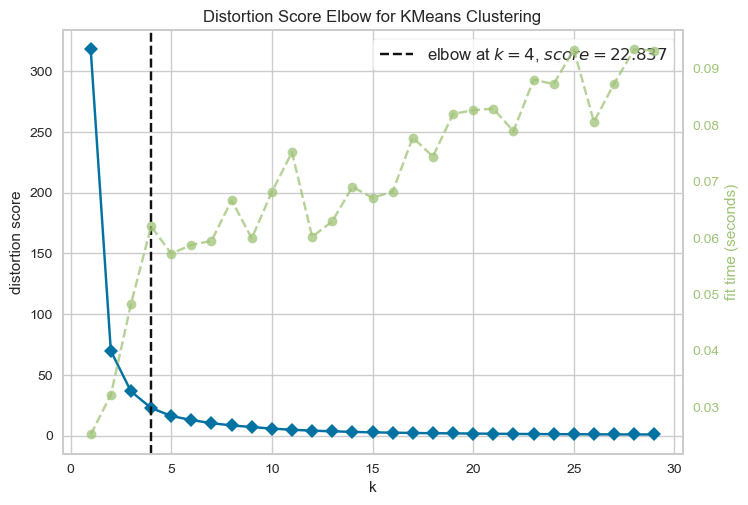

4

In [71]:
kmeans = KMeans(random_state=17)
ssd = []
K = range(1,30)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=17).fit(scaled_df)
    ssd.append(kmeans.inertia_)

kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(1, 30))
elbow.fit(scaled_df)
elbow.show()
elbow.elbow_value_ 

###### Creating final clusters according to the optimum cluster number found by the elbow method.


In [72]:
kmeans = KMeans(n_clusters=elbow.elbow_value_ , random_state=17).fit(scaled_df)
clusters = kmeans.labels_

In [73]:
rfm["KMeans_Segment"] = clusters
rfm["KMeans_Segment"] = rfm["KMeans_Segment"] + 1 

In [74]:
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,RFM_Segment,KMeans_Segment
Customer ID,,,,,,,,,
12346.0000,326,1,77183.6000,1,1,5,11,hibernating,3
12347.0000,3,7,4310.0000,5,5,5,55,champions,1
12348.0000,76,4,1797.2400,2,4,4,24,at_Risk,4
12349.0000,19,1,1757.5500,4,1,4,41,promising,1
12350.0000,311,1,334.4000,1,1,2,11,hibernating,3


###### How many customers are there in each cluster created by the K-means method?

In [75]:
rfm.groupby("KMeans_Segment").agg({"KMeans_Segment": "count"})

,KMeans_Segment
KMeans_Segment,
1,2210
2,598
3,497
4,1033


### COMPARISON

In [76]:
comparison_df = pd.DataFrame(rfm[["RFM_Segment", "KMeans_Segment"]].groupby(["KMeans_Segment", "RFM_Segment"])["RFM_Segment"].agg("count"))

In [77]:
comparison_df

RFM_Segment
KMeans_Segment RFM_Segment                     
1              about_to_sleep               166
               champions                    633
               loyal_customers              696
               need_attention                95
               new_customers                 42
               potential_loyalists          484
               promising                     94
2              at_Risk                      227
               cant_loose                    15
               hibernating                  356
3              at_Risk                       63
               cant_loose                     5
               hibernating                  429
4              about_to_sleep               186
               at_Risk                      303
               cant_loose                    43
               hibernating                  286
               loyal_customers              123
               need_attention                92